
# Follow-Me Project
Congratulations on reaching the final project of the Robotics Nanodegree! 

Previously, you worked on the Semantic Segmentation lab where you built a deep learning network that locates a particular human target within an image. For this project, you will utilize what you implemented and learned from that lab and extend it to train a deep learning model that will allow a simulated quadcopter to follow around the person that it detects! 

Most of the code below is similar to the lab with some minor modifications. You can start with your existing solution, and modify and improve upon it to train the best possible model for this task.

You can click on any of the following to quickly jump to that part of this notebook:
1. [Data Collection](#data)
2. [FCN Layers](#fcn)
3. [Build the Model](#build)
4. [Training](#training)
5. [Prediction](#prediction)
6. [Evaluation](#evaluation)

## Data Collection<a id='data'></a>
We have provided you with a starting dataset for this project. Download instructions can be found in the README for this project's repo.
Alternatively, you can collect additional data of your own to improve your model. Check out the "Collecting Data" section in the Project Lesson in the Classroom for more details!

In [15]:
import os
import glob
import sys
import tensorflow as tf

from scipy import misc
import numpy as np

from tensorflow.contrib.keras.python import keras
from tensorflow.contrib.keras.python.keras import layers, models

from tensorflow import image

from utils import scoring_utils
from utils.separable_conv2d import SeparableConv2DKeras, BilinearUpSampling2D
from utils import data_iterator
from utils import plotting_tools 
from utils import model_tools

## FCN Layers <a id='fcn'></a>
In the Classroom, we discussed the different layers that constitute a fully convolutional network (FCN). The following code will introduce you to the functions that you need to build your semantic segmentation model.

### Separable Convolutions
The Encoder for your FCN will essentially require separable convolution layers, due to their advantages as explained in the classroom. The 1x1 convolution layer in the FCN, however, is a regular convolution. Implementations for both are provided below for your use. Each includes batch normalization with the ReLU activation function applied to the layers. 

In [16]:
def separable_conv2d_batchnorm(input_layer, filters, strides=1):
    output_layer = SeparableConv2DKeras(filters=filters,kernel_size=3, strides=strides,
                             padding='same', activation='relu')(input_layer)
    
    output_layer = layers.BatchNormalization()(output_layer) 
    return output_layer

def conv2d_batchnorm(input_layer, filters, kernel_size=3, strides=1):
    output_layer = layers.Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, 
                      padding='same', activation='relu')(input_layer)
    
    output_layer = layers.BatchNormalization()(output_layer) 
    return output_layer

### Bilinear Upsampling
The following helper function implements the bilinear upsampling layer. Upsampling by a factor of 2 is generally recommended, but you can try out different factors as well. Upsampling is used in the decoder block of the FCN.

In [17]:
def bilinear_upsample(input_layer):
    output_layer = BilinearUpSampling2D((2,2))(input_layer)
    return output_layer

## Build the Model <a id='build'></a>
In the following cells, you will build an FCN to train a model to detect and locate the hero target within an image. The steps are:
- Create an `encoder_block`
- Create a `decoder_block`
- Build the FCN consisting of encoder block(s), a 1x1 convolution, and decoder block(s).  This step requires experimentation with different numbers of layers and filter sizes to build your model.

### Encoder Block
Create an encoder block that includes a separable convolution layer using the `separable_conv2d_batchnorm()` function. The `filters` parameter defines the size or depth of the output layer. For example, 32 or 64. 

In [18]:
def encoder_block(input_layer, filters, strides):
    
    # TODO Create a separable convolution layer using the separable_conv2d_batchnorm() function.
    output_layer = separable_conv2d_batchnorm(input_layer, filters, strides)
    return output_layer

### Decoder Block
The decoder block is comprised of three parts:
- A bilinear upsampling layer using the upsample_bilinear() function. The current recommended factor for upsampling is set to 2.
- A layer concatenation step. This step is similar to skip connections. You will concatenate the upsampled small_ip_layer and the large_ip_layer.
- Some (one or two) additional separable convolution layers to extract some more spatial information from prior layers.

In [19]:
def decoder_block(small_ip_layer, large_ip_layer, filters):
    
    # TODO Upsample the small input layer using the bilinear_upsample() function.
    upsampled_layer = bilinear_upsample(small_ip_layer)
    # TODO Concatenate the upsampled and large input layers using layers.concatenate
    concatenated_layer = layers.concatenate([upsampled_layer, large_ip_layer])
    # TODO Add some number of separable convolution layers
    preoutput_layer = separable_conv2d_batchnorm(concatenated_layer, filters)
    output_layer = separable_conv2d_batchnorm(preoutput_layer, filters)
    return output_layer

### Model

Now that you have the encoder and decoder blocks ready, go ahead and build your FCN architecture! 

There are three steps:
- Add encoder blocks to build the encoder layers. This is similar to how you added regular convolutional layers in your CNN lab.
- Add a 1x1 Convolution layer using the conv2d_batchnorm() function. Remember that 1x1 Convolutions require a kernel and stride of 1.
- Add decoder blocks for the decoder layers.

In [20]:
def fcn_model(inputs, num_classes):
    
    # TODO Add Encoder Blocks. 
    # Remember that with each encoder layer, the depth of your model (the number of filters) increases.
    encoder_layer1 = encoder_block(inputs, 32, 2)
    encoder_layer2 = encoder_block(encoder_layer1, 64, 2)
    encoder_layer3 = encoder_block(encoder_layer2, 128, 2)
    # TODO Add 1x1 Convolution layer using conv2d_batchnorm().
    conv_layer = conv2d_batchnorm(encoder_layer3, 512 ,kernel_size=1,strides=1)
    # TODO: Add the same number of Decoder Blocks as the number of Encoder Blocks
    decoder_layer1 = decoder_block(conv_layer, encoder_layer2, 128)
    decoder_layer2 = decoder_block(decoder_layer1, encoder_layer1, 64)
    decoder_layer3 = decoder_block(decoder_layer2, inputs, 32)
    
    outputs = layers.Conv2D(num_classes, 3, activation='softmax', padding='same')(decoder_layer3)
    # The function returns the output layer of your model. "x" is the final layer obtained from the last decoder_block()

    return outputs

## Training <a id='training'></a>
The following cells will use the FCN you created and define an ouput layer based on the size of the processed image and the number of classes recognized. You will define the hyperparameters to compile and train your model.

Please Note: For this project, the helper code in `data_iterator.py` will resize the copter images to 160x160x3 to speed up training.

In [21]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""

image_hw = 160
image_shape = (image_hw, image_hw, 3)
inputs = layers.Input(image_shape)
num_classes = 3

# Call fcn_model()
output_layer = fcn_model(inputs, num_classes)

### Hyperparameters
Define and tune your hyperparameters.
- **batch_size**: number of training samples/images that get propagated through the network in a single pass.
- **num_epochs**: number of times the entire training dataset gets propagated through the network.
- **steps_per_epoch**: number of batches of training images that go through the network in 1 epoch. We have provided you with a default value. One recommended value to try would be based on the total number of images in training dataset divided by the batch_size.
- **validation_steps**: number of batches of validation images that go through the network in 1 epoch. This is similar to steps_per_epoch, except validation_steps is for the validation dataset. We have provided you with a default value for this as well.
- **workers**: maximum number of processes to spin up. This can affect your training speed and is dependent on your hardware. We have provided a recommended value to work with. 

In [22]:
learning_rate = 0.001
batch_size = 32
num_epochs = 100
steps_per_epoch = 130
validation_steps = 30
workers = 2

Epoch 1/100
129/130 [============================>.] - ETA: 0s - loss: 0.4955

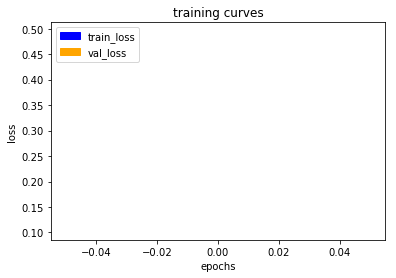

130/130 [==============================] - 85s - loss: 0.4923 - val_loss: 0.1049
Epoch 2/100
129/130 [============================>.] - ETA: 0s - loss: 0.0681

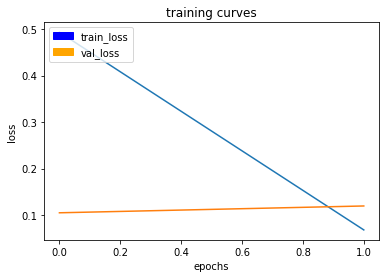

130/130 [==============================] - 83s - loss: 0.0680 - val_loss: 0.1196
Epoch 3/100
129/130 [============================>.] - ETA: 0s - loss: 0.0475

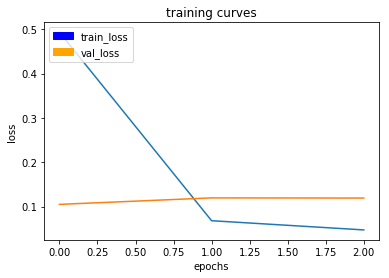

130/130 [==============================] - 83s - loss: 0.0474 - val_loss: 0.1192
Epoch 4/100
129/130 [============================>.] - ETA: 0s - loss: 0.0390

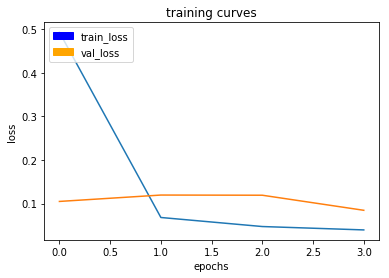

130/130 [==============================] - 83s - loss: 0.0459 - val_loss: 0.0846
Epoch 5/100
129/130 [============================>.] - ETA: 0s - loss: 0.0502

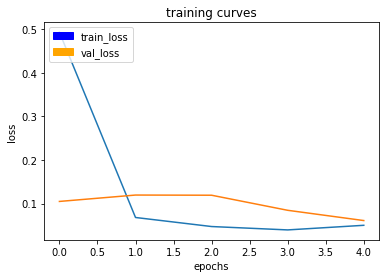

130/130 [==============================] - 83s - loss: 0.0501 - val_loss: 0.0611
Epoch 6/100
129/130 [============================>.] - ETA: 0s - loss: 0.0383

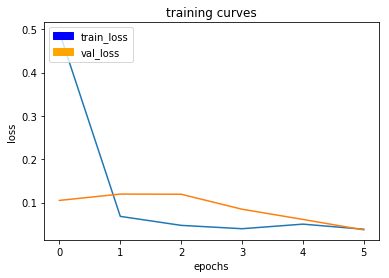

130/130 [==============================] - 83s - loss: 0.0392 - val_loss: 0.0369
Epoch 7/100
129/130 [============================>.] - ETA: 0s - loss: 0.0354

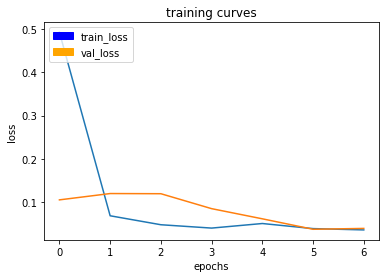

130/130 [==============================] - 83s - loss: 0.0353 - val_loss: 0.0388
Epoch 8/100
129/130 [============================>.] - ETA: 0s - loss: 0.0323

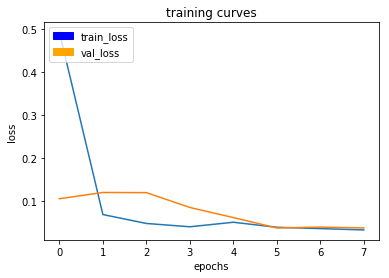

130/130 [==============================] - 83s - loss: 0.0323 - val_loss: 0.0370
Epoch 9/100
129/130 [============================>.] - ETA: 0s - loss: 0.0308

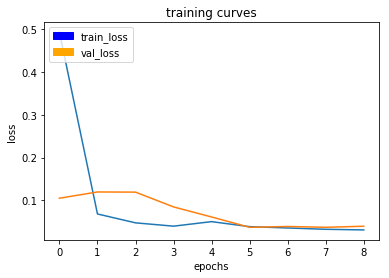

130/130 [==============================] - 83s - loss: 0.0308 - val_loss: 0.0394
Epoch 10/100
129/130 [============================>.] - ETA: 0s - loss: 0.0307

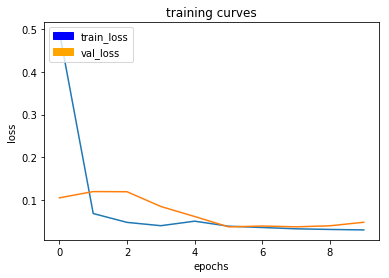

130/130 [==============================] - 83s - loss: 0.0307 - val_loss: 0.0477
Epoch 11/100
129/130 [============================>.] - ETA: 0s - loss: 0.0292

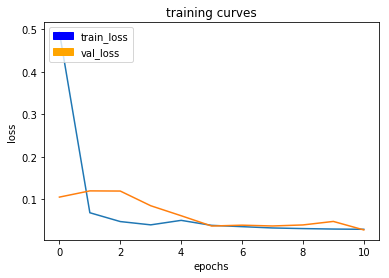

130/130 [==============================] - 83s - loss: 0.0292 - val_loss: 0.0277
Epoch 12/100
129/130 [============================>.] - ETA: 0s - loss: 0.0277

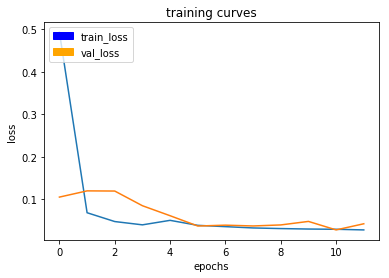

130/130 [==============================] - 83s - loss: 0.0277 - val_loss: 0.0421
Epoch 13/100
129/130 [============================>.] - ETA: 0s - loss: 0.0268

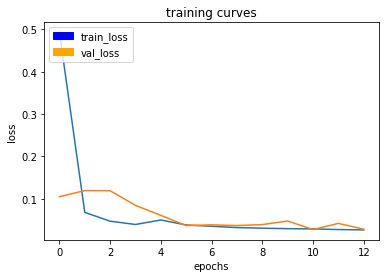

130/130 [==============================] - 83s - loss: 0.0268 - val_loss: 0.0284
Epoch 14/100
129/130 [============================>.] - ETA: 0s - loss: 0.0239

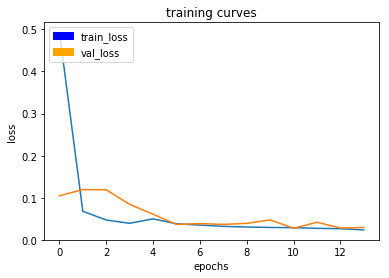

130/130 [==============================] - 83s - loss: 0.0239 - val_loss: 0.0298
Epoch 15/100
129/130 [============================>.] - ETA: 0s - loss: 0.0252

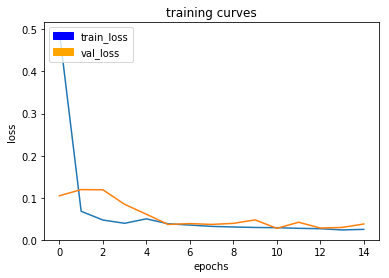

130/130 [==============================] - 83s - loss: 0.0252 - val_loss: 0.0380
Epoch 16/100
129/130 [============================>.] - ETA: 0s - loss: 0.0238

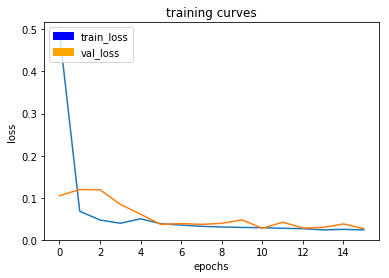

130/130 [==============================] - 83s - loss: 0.0240 - val_loss: 0.0271
Epoch 17/100
129/130 [============================>.] - ETA: 0s - loss: 0.0256

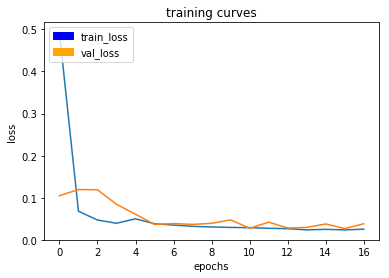

130/130 [==============================] - 83s - loss: 0.0256 - val_loss: 0.0384
Epoch 18/100
129/130 [============================>.] - ETA: 0s - loss: 0.0229

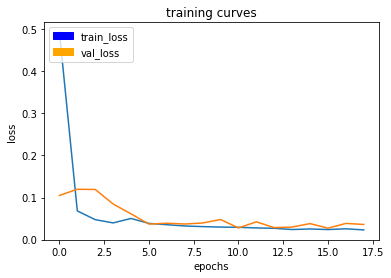

130/130 [==============================] - 83s - loss: 0.0230 - val_loss: 0.0359
Epoch 19/100
129/130 [============================>.] - ETA: 0s - loss: 0.0220

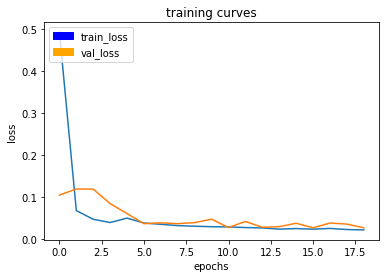

130/130 [==============================] - 83s - loss: 0.0222 - val_loss: 0.0270
Epoch 20/100
129/130 [============================>.] - ETA: 0s - loss: 0.0231

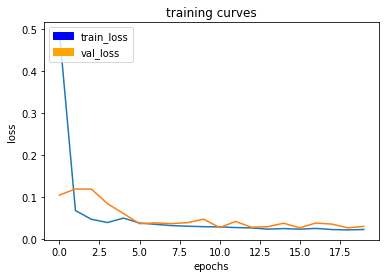

130/130 [==============================] - 83s - loss: 0.0231 - val_loss: 0.0304
Epoch 21/100
129/130 [============================>.] - ETA: 0s - loss: 0.0210

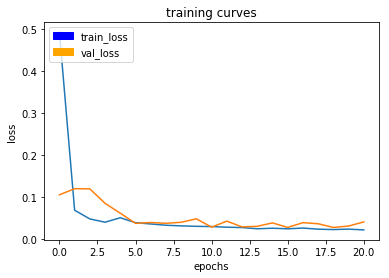

130/130 [==============================] - 83s - loss: 0.0212 - val_loss: 0.0402
Epoch 22/100
129/130 [============================>.] - ETA: 0s - loss: 0.0202

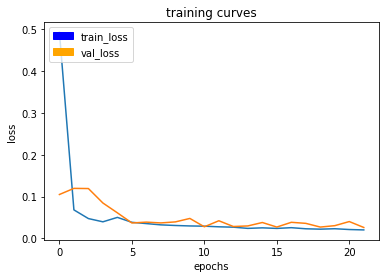

130/130 [==============================] - 83s - loss: 0.0203 - val_loss: 0.0261
Epoch 23/100
129/130 [============================>.] - ETA: 0s - loss: 0.0204

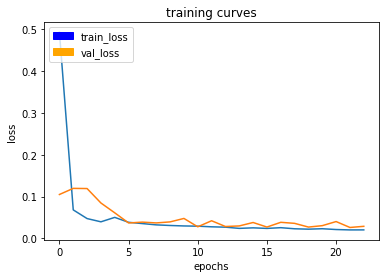

130/130 [==============================] - 83s - loss: 0.0204 - val_loss: 0.0288
Epoch 24/100
129/130 [============================>.] - ETA: 0s - loss: 0.0188

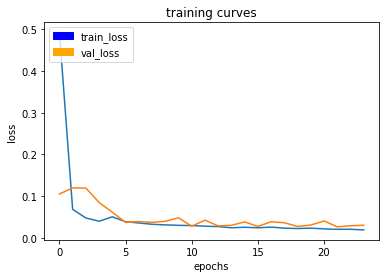

130/130 [==============================] - 83s - loss: 0.0188 - val_loss: 0.0299
Epoch 25/100
129/130 [============================>.] - ETA: 0s - loss: 0.0204

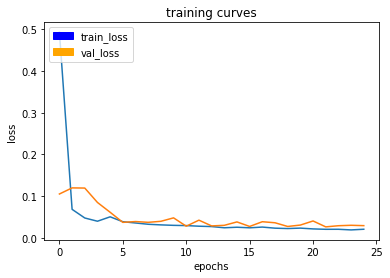

130/130 [==============================] - 83s - loss: 0.0205 - val_loss: 0.0290
Epoch 26/100
129/130 [============================>.] - ETA: 0s - loss: 0.0184

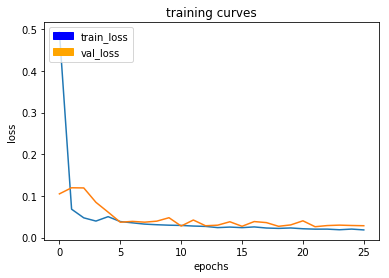

130/130 [==============================] - 83s - loss: 0.0184 - val_loss: 0.0284
Epoch 27/100
129/130 [============================>.] - ETA: 0s - loss: 0.0167

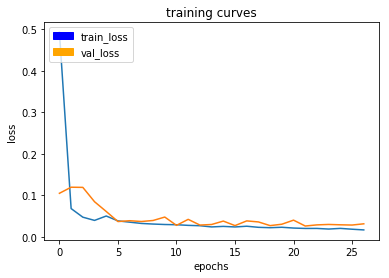

130/130 [==============================] - 83s - loss: 0.0168 - val_loss: 0.0314
Epoch 28/100
129/130 [============================>.] - ETA: 0s - loss: 0.0178

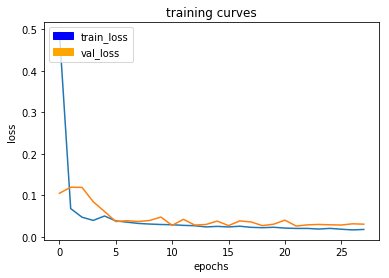

130/130 [==============================] - 83s - loss: 0.0178 - val_loss: 0.0306
Epoch 29/100
129/130 [============================>.] - ETA: 0s - loss: 0.0181

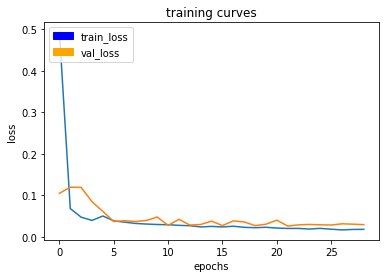

130/130 [==============================] - 83s - loss: 0.0181 - val_loss: 0.0294
Epoch 30/100
129/130 [============================>.] - ETA: 0s - loss: 0.0173

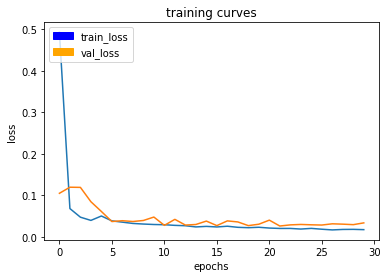

130/130 [==============================] - 83s - loss: 0.0173 - val_loss: 0.0336
Epoch 31/100
129/130 [============================>.] - ETA: 0s - loss: 0.0173

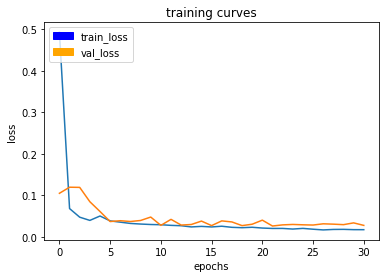

130/130 [==============================] - 83s - loss: 0.0173 - val_loss: 0.0276
Epoch 32/100
129/130 [============================>.] - ETA: 0s - loss: 0.0163

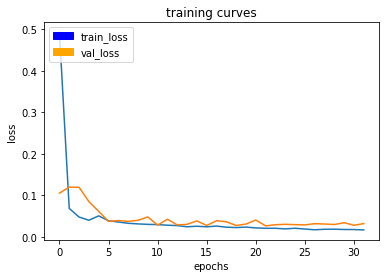

130/130 [==============================] - 83s - loss: 0.0163 - val_loss: 0.0315
Epoch 33/100
129/130 [============================>.] - ETA: 0s - loss: 0.0157

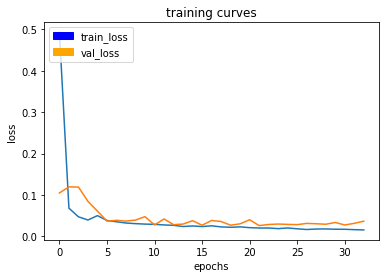

130/130 [==============================] - 83s - loss: 0.0156 - val_loss: 0.0368
Epoch 34/100
129/130 [============================>.] - ETA: 0s - loss: 0.0182

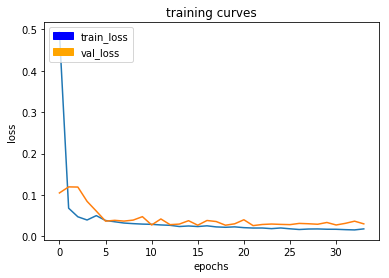

130/130 [==============================] - 83s - loss: 0.0182 - val_loss: 0.0303
Epoch 35/100
129/130 [============================>.] - ETA: 0s - loss: 0.0158

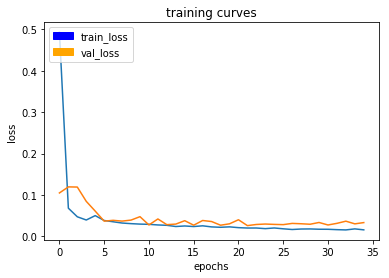

130/130 [==============================] - 83s - loss: 0.0159 - val_loss: 0.0334
Epoch 36/100
129/130 [============================>.] - ETA: 0s - loss: 0.0146

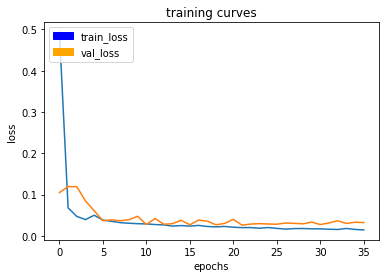

130/130 [==============================] - 83s - loss: 0.0146 - val_loss: 0.0324
Epoch 37/100
129/130 [============================>.] - ETA: 0s - loss: 0.0151

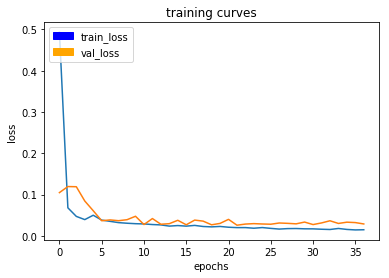

130/130 [==============================] - 83s - loss: 0.0151 - val_loss: 0.0291
Epoch 38/100
129/130 [============================>.] - ETA: 0s - loss: 0.0144

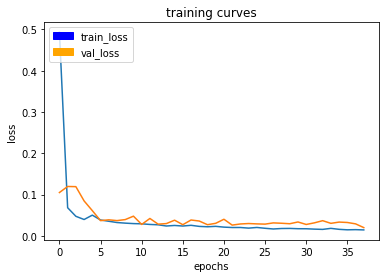

130/130 [==============================] - 83s - loss: 0.0145 - val_loss: 0.0200
Epoch 39/100
129/130 [============================>.] - ETA: 0s - loss: 0.0162

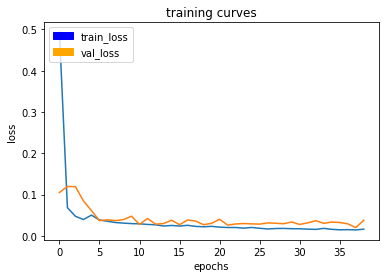

130/130 [==============================] - 83s - loss: 0.0162 - val_loss: 0.0379
Epoch 40/100
129/130 [============================>.] - ETA: 0s - loss: 0.0155

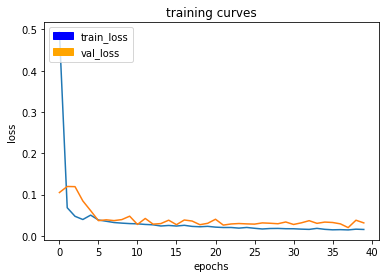

130/130 [==============================] - 83s - loss: 0.0155 - val_loss: 0.0314
Epoch 41/100
129/130 [============================>.] - ETA: 0s - loss: 0.0141

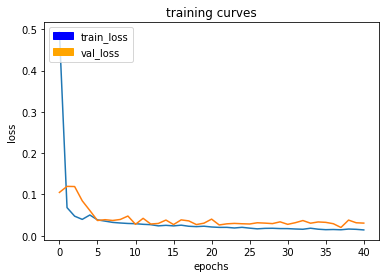

130/130 [==============================] - 83s - loss: 0.0141 - val_loss: 0.0306
Epoch 42/100
129/130 [============================>.] - ETA: 0s - loss: 0.0145

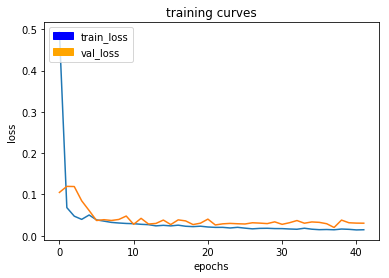

130/130 [==============================] - 83s - loss: 0.0145 - val_loss: 0.0304
Epoch 43/100
129/130 [============================>.] - ETA: 0s - loss: 0.0154

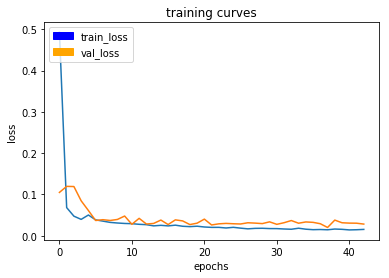

130/130 [==============================] - 83s - loss: 0.0154 - val_loss: 0.0282
Epoch 44/100
129/130 [============================>.] - ETA: 0s - loss: 0.0145

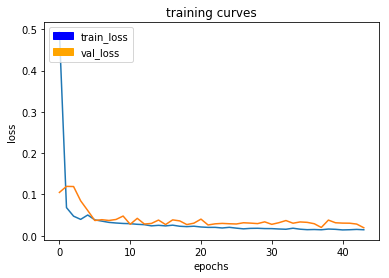

130/130 [==============================] - 83s - loss: 0.0144 - val_loss: 0.0193
Epoch 45/100
129/130 [============================>.] - ETA: 0s - loss: 0.0142

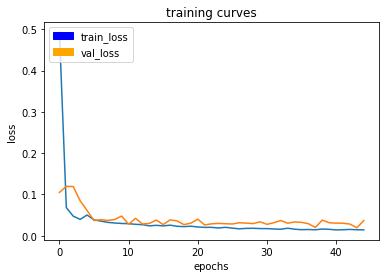

130/130 [==============================] - 83s - loss: 0.0142 - val_loss: 0.0368
Epoch 46/100
129/130 [============================>.] - ETA: 0s - loss: 0.0141

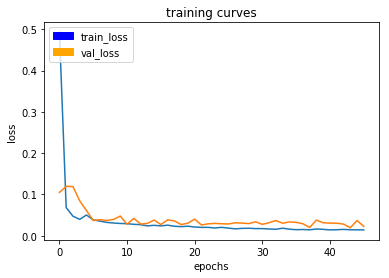

130/130 [==============================] - 83s - loss: 0.0141 - val_loss: 0.0226
Epoch 47/100
129/130 [============================>.] - ETA: 0s - loss: 0.0128

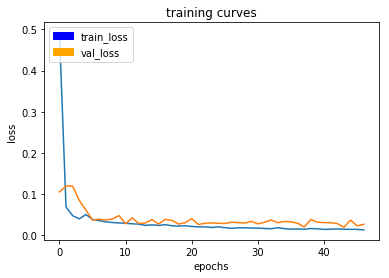

130/130 [==============================] - 83s - loss: 0.0128 - val_loss: 0.0265
Epoch 48/100
129/130 [============================>.] - ETA: 0s - loss: 0.0132

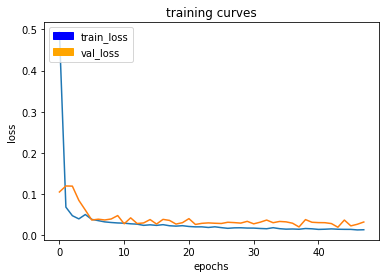

130/130 [==============================] - 83s - loss: 0.0132 - val_loss: 0.0321
Epoch 49/100
129/130 [============================>.] - ETA: 0s - loss: 0.0125

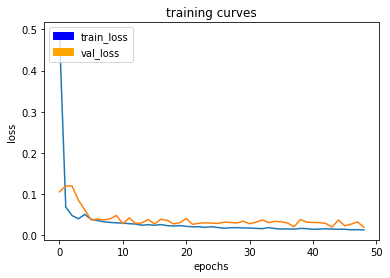

130/130 [==============================] - 83s - loss: 0.0126 - val_loss: 0.0189
Epoch 50/100
129/130 [============================>.] - ETA: 0s - loss: 0.0126

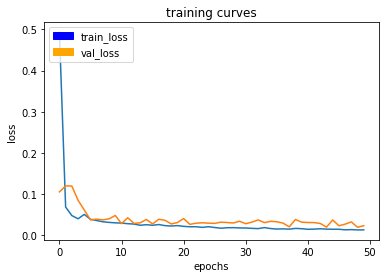

130/130 [==============================] - 82s - loss: 0.0127 - val_loss: 0.0230
Epoch 51/100
129/130 [============================>.] - ETA: 0s - loss: 0.0118

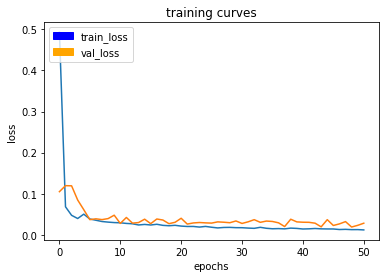

130/130 [==============================] - 83s - loss: 0.0118 - val_loss: 0.0282
Epoch 52/100
129/130 [============================>.] - ETA: 0s - loss: 0.0115

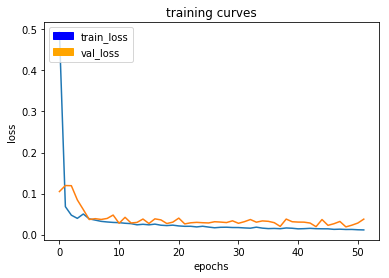

130/130 [==============================] - 83s - loss: 0.0114 - val_loss: 0.0377
Epoch 53/100
129/130 [============================>.] - ETA: 0s - loss: 0.0110

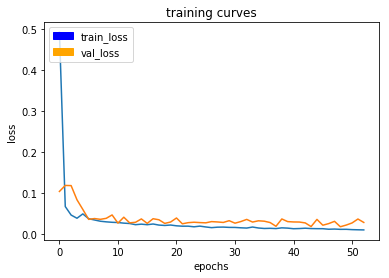

130/130 [==============================] - 83s - loss: 0.0111 - val_loss: 0.0294
Epoch 54/100
129/130 [============================>.] - ETA: 0s - loss: 0.0191

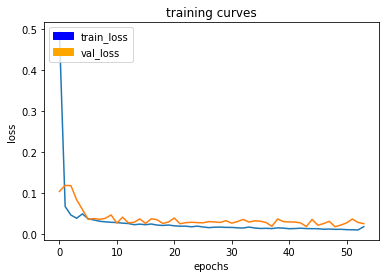

130/130 [==============================] - 83s - loss: 0.0191 - val_loss: 0.0266
Epoch 55/100
129/130 [============================>.] - ETA: 0s - loss: 0.0169

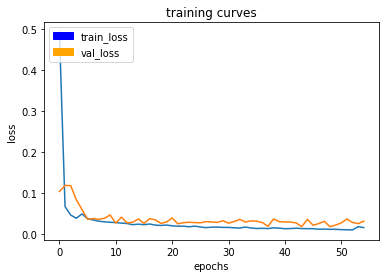

130/130 [==============================] - 83s - loss: 0.0170 - val_loss: 0.0325
Epoch 56/100
129/130 [============================>.] - ETA: 0s - loss: 0.0145

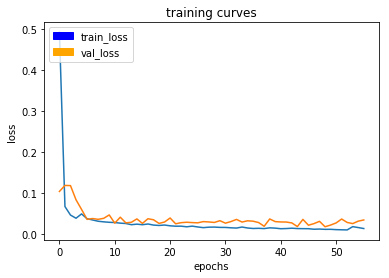

130/130 [==============================] - 83s - loss: 0.0145 - val_loss: 0.0354
Epoch 57/100
129/130 [============================>.] - ETA: 0s - loss: 0.0120

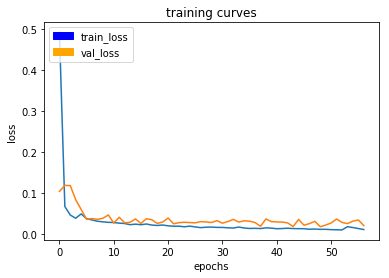

130/130 [==============================] - 82s - loss: 0.0121 - val_loss: 0.0217
Epoch 58/100
129/130 [============================>.] - ETA: 0s - loss: 0.0117

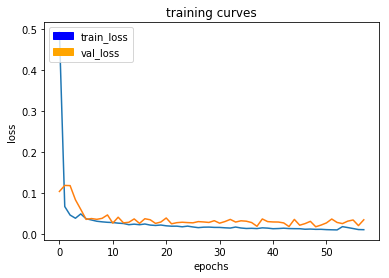

130/130 [==============================] - 83s - loss: 0.0117 - val_loss: 0.0358
Epoch 59/100
129/130 [============================>.] - ETA: 0s - loss: 0.0112

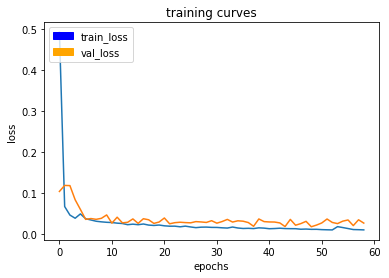

130/130 [==============================] - 83s - loss: 0.0113 - val_loss: 0.0278
Epoch 60/100
129/130 [============================>.] - ETA: 0s - loss: 0.0113

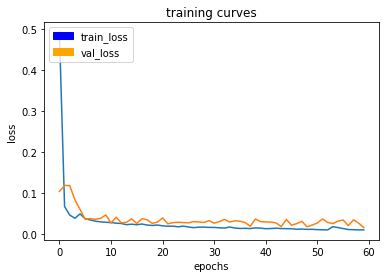

130/130 [==============================] - 83s - loss: 0.0113 - val_loss: 0.0169
Epoch 61/100
129/130 [============================>.] - ETA: 0s - loss: 0.0110

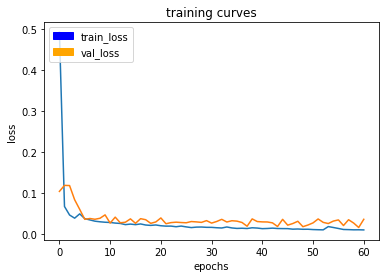

130/130 [==============================] - 83s - loss: 0.0110 - val_loss: 0.0369
Epoch 62/100
129/130 [============================>.] - ETA: 0s - loss: 0.0112

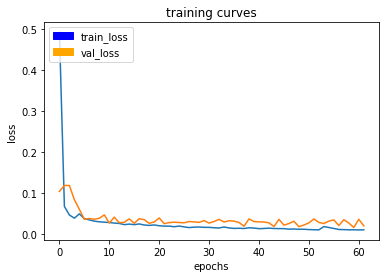

130/130 [==============================] - 83s - loss: 0.0112 - val_loss: 0.0210
Epoch 63/100
129/130 [============================>.] - ETA: 0s - loss: 0.0108

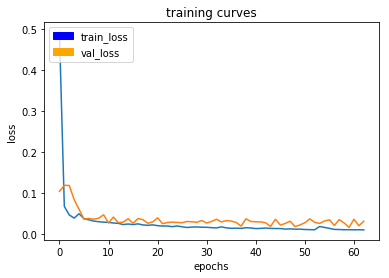

130/130 [==============================] - 83s - loss: 0.0108 - val_loss: 0.0320
Epoch 64/100
129/130 [============================>.] - ETA: 0s - loss: 0.0107

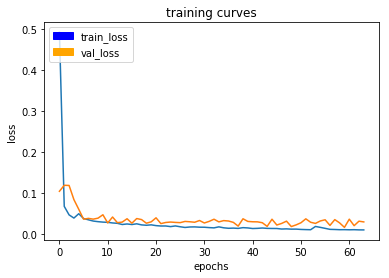

130/130 [==============================] - 83s - loss: 0.0109 - val_loss: 0.0302
Epoch 65/100
129/130 [============================>.] - ETA: 0s - loss: 0.0187

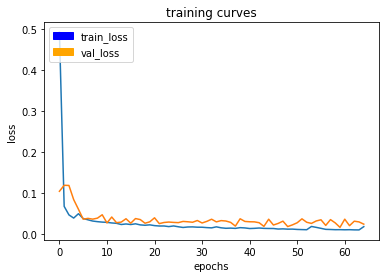

130/130 [==============================] - 83s - loss: 0.0187 - val_loss: 0.0247
Epoch 66/100
129/130 [============================>.] - ETA: 0s - loss: 0.0145

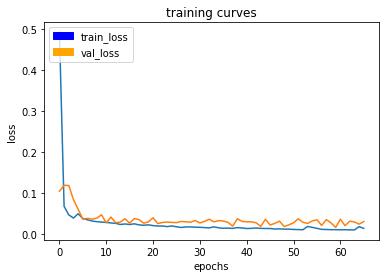

130/130 [==============================] - 83s - loss: 0.0145 - val_loss: 0.0310
Epoch 67/100
129/130 [============================>.] - ETA: 0s - loss: 0.0121

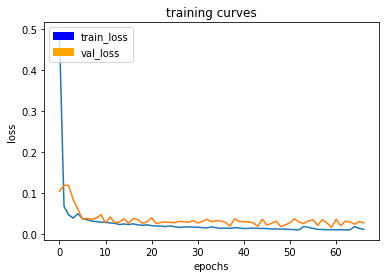

130/130 [==============================] - 83s - loss: 0.0121 - val_loss: 0.0277
Epoch 68/100
129/130 [============================>.] - ETA: 0s - loss: 0.0112

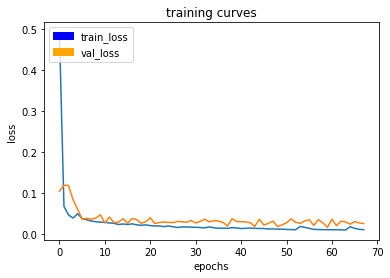

130/130 [==============================] - 83s - loss: 0.0112 - val_loss: 0.0261
Epoch 69/100
129/130 [============================>.] - ETA: 0s - loss: 0.0105

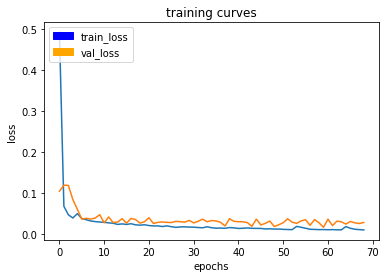

130/130 [==============================] - 83s - loss: 0.0105 - val_loss: 0.0286
Epoch 70/100
129/130 [============================>.] - ETA: 0s - loss: 0.0106

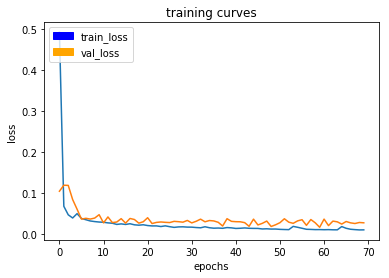

130/130 [==============================] - 83s - loss: 0.0106 - val_loss: 0.0278
Epoch 71/100
129/130 [============================>.] - ETA: 0s - loss: 0.0108

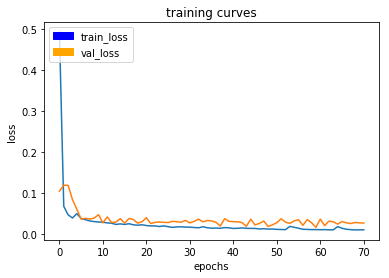

130/130 [==============================] - 82s - loss: 0.0108 - val_loss: 0.0272
Epoch 72/100
129/130 [============================>.] - ETA: 0s - loss: 0.0102

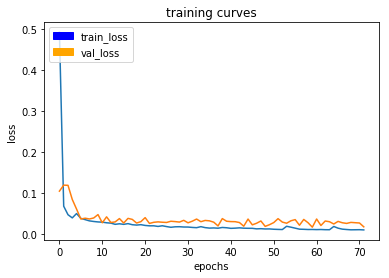

130/130 [==============================] - 83s - loss: 0.0102 - val_loss: 0.0177
Epoch 73/100
129/130 [============================>.] - ETA: 0s - loss: 0.0118

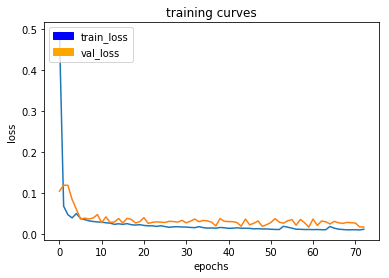

130/130 [==============================] - 83s - loss: 0.0117 - val_loss: 0.0169
Epoch 74/100
129/130 [============================>.] - ETA: 0s - loss: 0.0124

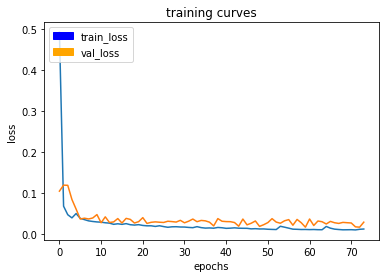

130/130 [==============================] - 83s - loss: 0.0124 - val_loss: 0.0291
Epoch 75/100
129/130 [============================>.] - ETA: 0s - loss: 0.0111

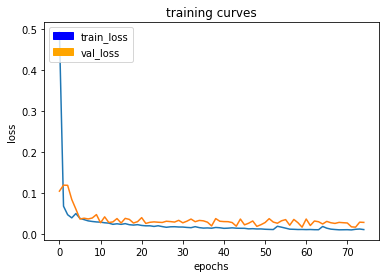

130/130 [==============================] - 83s - loss: 0.0111 - val_loss: 0.0286
Epoch 76/100
129/130 [============================>.] - ETA: 0s - loss: 0.0143

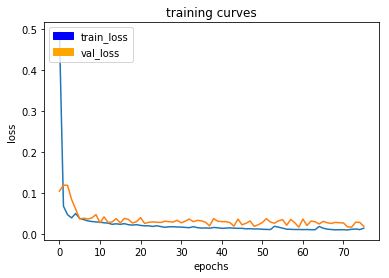

130/130 [==============================] - 83s - loss: 0.0144 - val_loss: 0.0189
Epoch 77/100
129/130 [============================>.] - ETA: 0s - loss: 0.0129

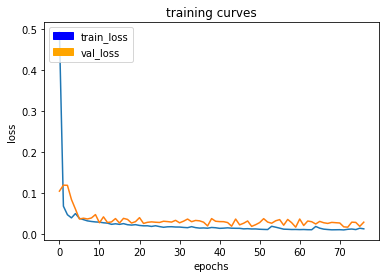

130/130 [==============================] - 83s - loss: 0.0130 - val_loss: 0.0291
Epoch 78/100
129/130 [============================>.] - ETA: 0s - loss: 0.0115

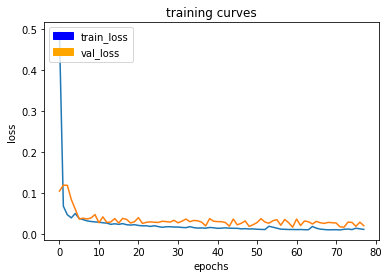

130/130 [==============================] - 83s - loss: 0.0116 - val_loss: 0.0206
Epoch 79/100
129/130 [============================>.] - ETA: 0s - loss: 0.0152

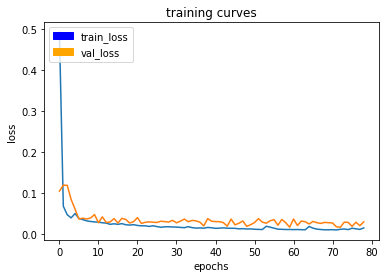

130/130 [==============================] - 83s - loss: 0.0152 - val_loss: 0.0299
Epoch 80/100
129/130 [============================>.] - ETA: 0s - loss: 0.0131

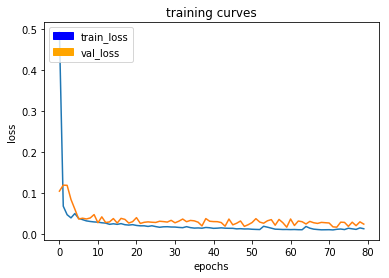

130/130 [==============================] - 83s - loss: 0.0131 - val_loss: 0.0244
Epoch 81/100
129/130 [============================>.] - ETA: 0s - loss: 0.0106

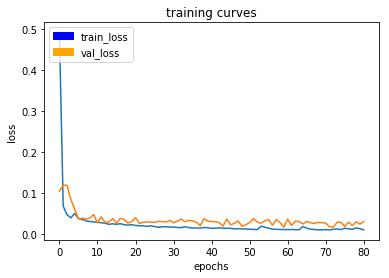

130/130 [==============================] - 83s - loss: 0.0106 - val_loss: 0.0306
Epoch 82/100
129/130 [============================>.] - ETA: 0s - loss: 0.0113

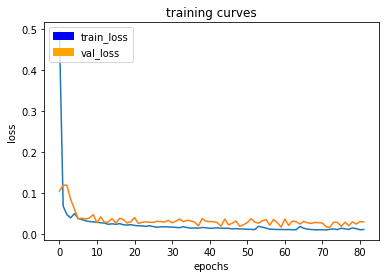

130/130 [==============================] - 83s - loss: 0.0113 - val_loss: 0.0297
Epoch 83/100
129/130 [============================>.] - ETA: 0s - loss: 0.0113

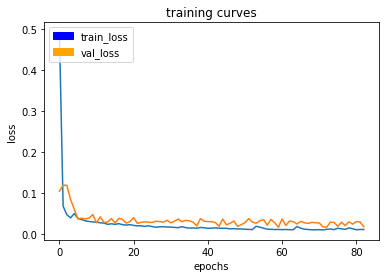

130/130 [==============================] - 83s - loss: 0.0113 - val_loss: 0.0179
Epoch 84/100
129/130 [============================>.] - ETA: 0s - loss: 0.0101

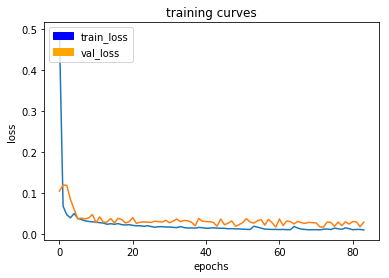

130/130 [==============================] - 83s - loss: 0.0101 - val_loss: 0.0292
Epoch 85/100
129/130 [============================>.] - ETA: 0s - loss: 0.0101

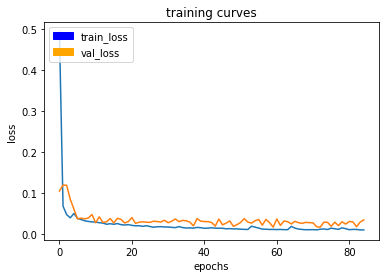

130/130 [==============================] - 83s - loss: 0.0101 - val_loss: 0.0346
Epoch 86/100
129/130 [============================>.] - ETA: 0s - loss: 0.0096

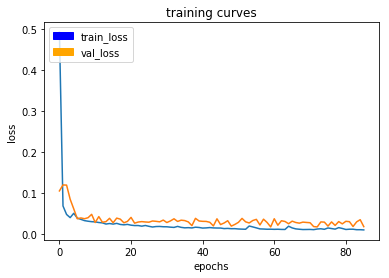

130/130 [==============================] - 83s - loss: 0.0096 - val_loss: 0.0176
Epoch 87/100
129/130 [============================>.] - ETA: 0s - loss: 0.0095

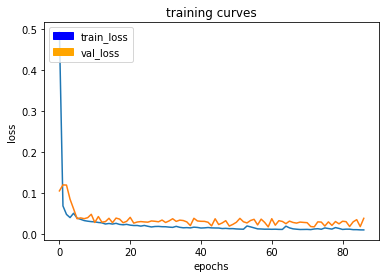

130/130 [==============================] - 83s - loss: 0.0095 - val_loss: 0.0378
Epoch 88/100
129/130 [============================>.] - ETA: 0s - loss: 0.0094

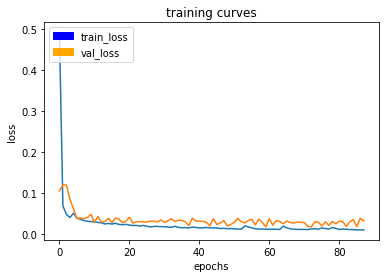

130/130 [==============================] - 83s - loss: 0.0094 - val_loss: 0.0312
Epoch 89/100
129/130 [============================>.] - ETA: 0s - loss: 0.0093

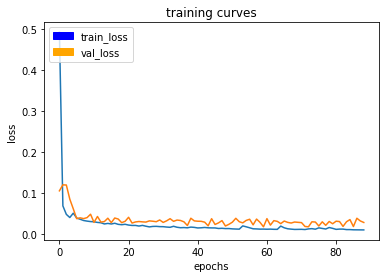

130/130 [==============================] - 83s - loss: 0.0093 - val_loss: 0.0275
Epoch 90/100
129/130 [============================>.] - ETA: 0s - loss: 0.0092

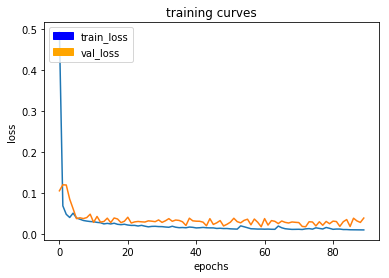

130/130 [==============================] - 83s - loss: 0.0092 - val_loss: 0.0382
Epoch 91/100
129/130 [============================>.] - ETA: 0s - loss: 0.0100

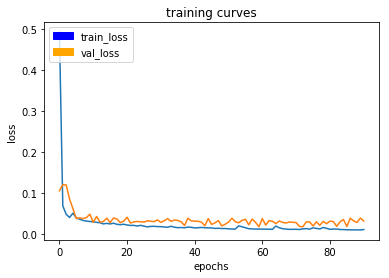

130/130 [==============================] - 83s - loss: 0.0100 - val_loss: 0.0308
Epoch 92/100
129/130 [============================>.] - ETA: 0s - loss: 0.0092

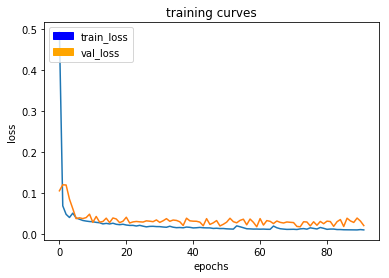

130/130 [==============================] - 83s - loss: 0.0092 - val_loss: 0.0198
Epoch 93/100
129/130 [============================>.] - ETA: 0s - loss: 0.0091

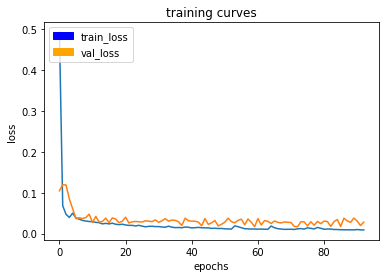

130/130 [==============================] - 83s - loss: 0.0091 - val_loss: 0.0282
Epoch 94/100
129/130 [============================>.] - ETA: 0s - loss: 0.0092

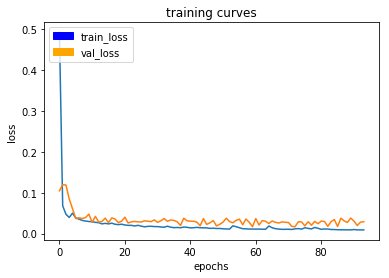

130/130 [==============================] - 83s - loss: 0.0091 - val_loss: 0.0291
Epoch 95/100
129/130 [============================>.] - ETA: 0s - loss: 0.0090

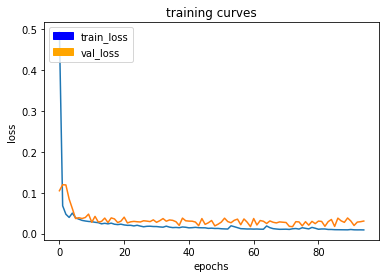

130/130 [==============================] - 82s - loss: 0.0090 - val_loss: 0.0307
Epoch 96/100
129/130 [============================>.] - ETA: 0s - loss: 0.0089

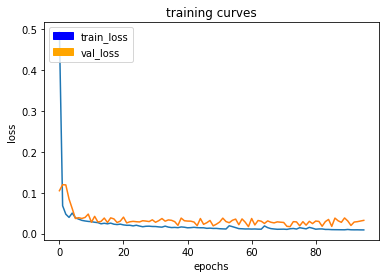

130/130 [==============================] - 83s - loss: 0.0089 - val_loss: 0.0323
Epoch 97/100
129/130 [============================>.] - ETA: 0s - loss: 0.0095

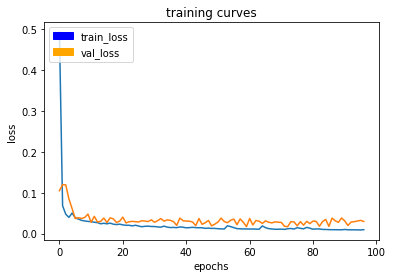

130/130 [==============================] - 82s - loss: 0.0095 - val_loss: 0.0295
Epoch 98/100
129/130 [============================>.] - ETA: 0s - loss: 0.0091

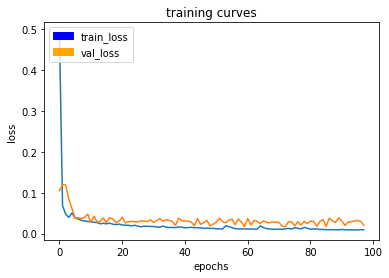

130/130 [==============================] - 83s - loss: 0.0090 - val_loss: 0.0207
Epoch 99/100
129/130 [============================>.] - ETA: 0s - loss: 0.0090

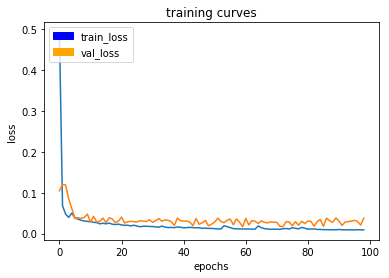

130/130 [==============================] - 83s - loss: 0.0091 - val_loss: 0.0379
Epoch 100/100
129/130 [============================>.] - ETA: 0s - loss: 0.0096

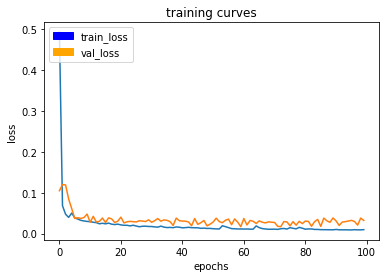

130/130 [==============================] - 83s - loss: 0.0096 - val_loss: 0.0321


In [23]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Define the Keras model and compile it for training
model = models.Model(inputs=inputs, outputs=output_layer)

model.compile(optimizer=keras.optimizers.Adam(learning_rate), loss='categorical_crossentropy')

# Data iterators for loading the training and validation data
train_iter = data_iterator.BatchIteratorSimple(batch_size=batch_size,
                                               data_folder=os.path.join('..', 'data', 'train'),
                                               image_shape=image_shape,
                                               shift_aug=True)

val_iter = data_iterator.BatchIteratorSimple(batch_size=batch_size,
                                             data_folder=os.path.join('..', 'data', 'validation'),
                                             image_shape=image_shape)

logger_cb = plotting_tools.LoggerPlotter()
callbacks = [logger_cb]

model.fit_generator(train_iter,
                    steps_per_epoch = steps_per_epoch, # the number of batches per epoch,
                    epochs = num_epochs, # the number of epochs to train for,
                    validation_data = val_iter, # validation iterator
                    validation_steps = validation_steps, # the number of batches to validate on
                    callbacks=callbacks,
                    workers = workers)

In [28]:
# Save your trained model weights
weight_file_name = 'model_weights'
model_tools.save_network(model, weight_file_name)

## Prediction <a id='prediction'></a>

Now that you have your model trained and saved, you can make predictions on your validation dataset. These predictions can be compared to the mask images, which are the ground truth labels, to evaluate how well your model is doing under different conditions.

There are three different predictions available from the helper code provided:
- **patrol_with_targ**: Test how well the network can detect the hero from a distance.
- **patrol_non_targ**: Test how often the network makes a mistake and identifies the wrong person as the target.
- **following_images**: Test how well the network can identify the target while following them.

In [29]:
# If you need to load a model which you previously trained you can uncomment the codeline that calls the function below.

# weight_file_name = 'model_weights'
# restored_model = model_tools.load_network(weight_file_name)

The following cell will write predictions to files and return paths to the appropriate directories.
The `run_num` parameter is used to define or group all the data for a particular model run. You can change it for different runs. For example, 'run_1', 'run_2' etc.

In [30]:
run_num = 'run_1'

val_with_targ, pred_with_targ = model_tools.write_predictions_grade_set(model,
                                        run_num,'patrol_with_targ', 'sample_evaluation_data') 

val_no_targ, pred_no_targ = model_tools.write_predictions_grade_set(model, 
                                        run_num,'patrol_non_targ', 'sample_evaluation_data') 

val_following, pred_following = model_tools.write_predictions_grade_set(model,
                                        run_num,'following_images', 'sample_evaluation_data')

Now lets look at your predictions, and compare them to the ground truth labels and original images.
Run each of the following cells to visualize some sample images from the predictions in the validation set.

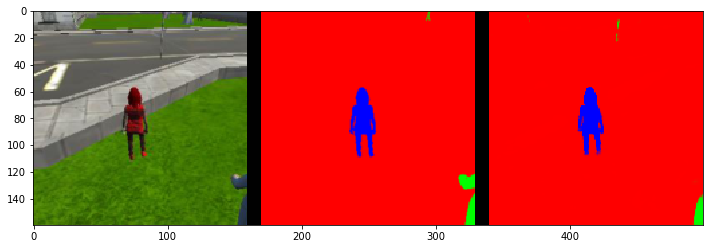

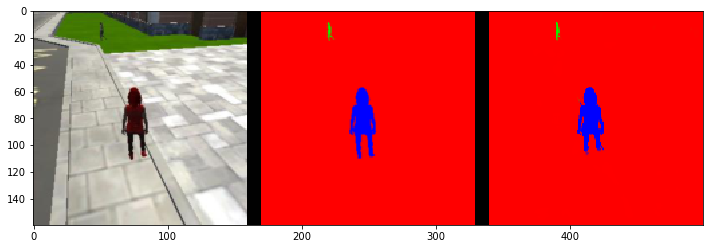

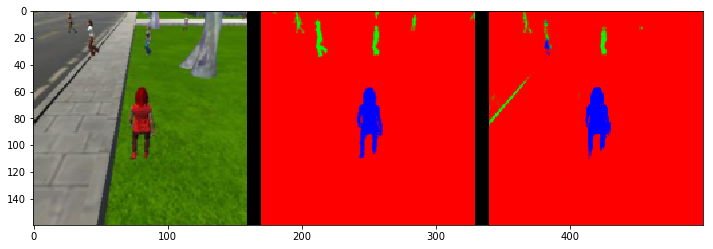

In [31]:
# images while following the target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','following_images', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)
    

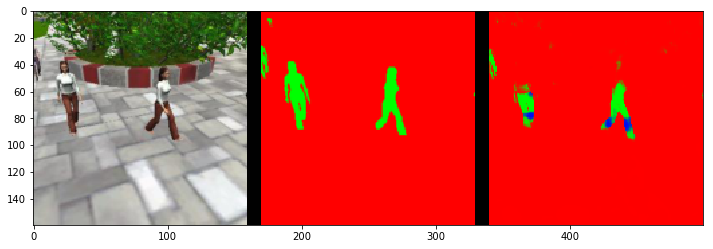

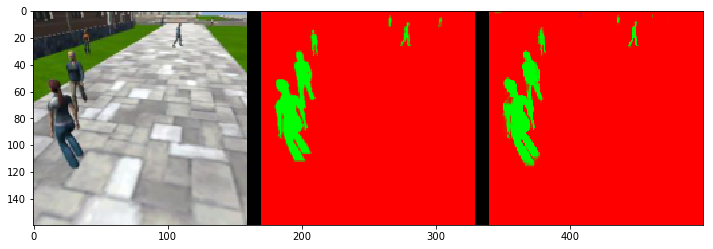

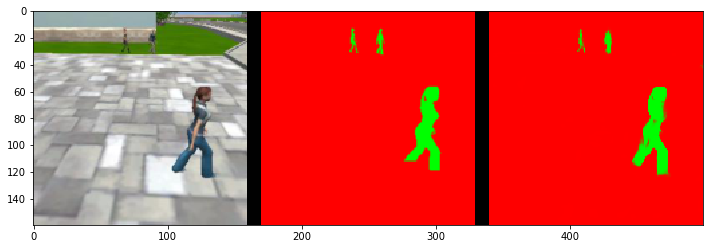

In [32]:
# images while at patrol without target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','patrol_non_targ', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)
 

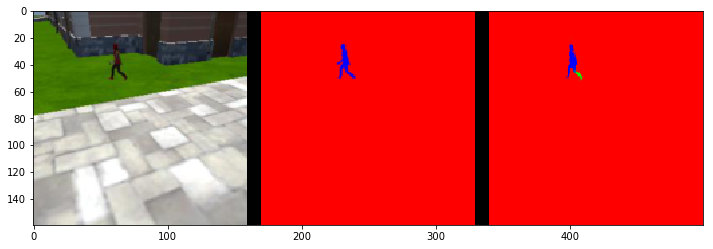

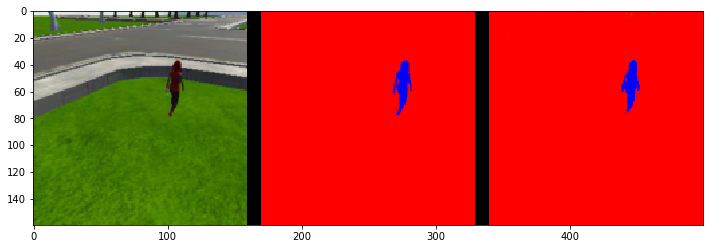

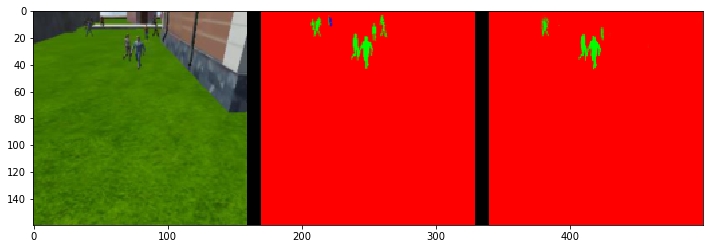

In [33]:
   
# images while at patrol with target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','patrol_with_targ', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)

## Evaluation <a id='evaluation'></a>
Evaluate your model! The following cells include several different scores to help you evaluate your model under the different conditions discussed during the Prediction step. 

In [34]:
# Scores for while the quad is following behind the target. 
true_pos1, false_pos1, false_neg1, iou1 = scoring_utils.score_run_iou(val_following, pred_following)

number of validation samples intersection over the union evaulated on 542
average intersection over union for background is 0.9957462006938519
average intersection over union for other people is 0.3743204647155872
average intersection over union for the hero is 0.9249739897229124
number true positives: 539, number false positives: 0, number false negatives: 0


In [35]:
# Scores for images while the quad is on patrol and the target is not visable
true_pos2, false_pos2, false_neg2, iou2 = scoring_utils.score_run_iou(val_no_targ, pred_no_targ)

number of validation samples intersection over the union evaulated on 270
average intersection over union for background is 0.9890414043127754
average intersection over union for other people is 0.7669494679453651
average intersection over union for the hero is 0.0
number true positives: 0, number false positives: 95, number false negatives: 0


In [36]:
# This score measures how well the neural network can detect the target from far away
true_pos3, false_pos3, false_neg3, iou3 = scoring_utils.score_run_iou(val_with_targ, pred_with_targ)

number of validation samples intersection over the union evaulated on 322
average intersection over union for background is 0.9969186556815561
average intersection over union for other people is 0.46696706024917606
average intersection over union for the hero is 0.24349048047784033
number true positives: 137, number false positives: 2, number false negatives: 164


In [37]:
# Sum all the true positives, etc from the three datasets to get a weight for the score
true_pos = true_pos1 + true_pos2 + true_pos3
false_pos = false_pos1 + false_pos2 + false_pos3
false_neg = false_neg1 + false_neg2 + false_neg3

weight = true_pos/(true_pos+false_neg+false_pos)
print(weight)

0.7214514407684098


In [38]:
# The IoU for the dataset that never includes the hero is excluded from grading
final_IoU = (iou1 + iou3)/2
print(final_IoU)

0.5842322351


In [39]:
# And the final grade score is 
final_score = final_IoU * weight
print(final_score)

0.421495187757
